In [215]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import requests
from shapely.geometry import Point
from shapely.wkt import loads
from scipy.spatial import distance_matrix
import numpy as np
from tqdm import tqdm

In [2]:
def load_data(url):
    response = requests.get(url)
    json_data = response.json()
    data = json_data["value"]
    df = pd.DataFrame(data)
    return df

In [99]:
def load_parcels():
    df_p = (
        pd.read_csv("data/parcels.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["the_geom"])
    ).sample(100_000)
    df_p["geometry"] = df_p["the_geom"].apply(loads)
    df_p = gpd.GeoDataFrame(df_p, geometry="geometry")
    return df_p

df_p = load_parcels()
df_p

/Users/gauravsett/Documents/GitHub/sf-eviction-forecasting/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()


,closed_roll_year,property_location,parcel_number,block,lot,volume_number,use_code,use_definition,property_class_code,property_class_code_definition,...,current_supervisor_districts_2,analysis_neighborhoods_2,delete_-_supervisor_districts_2,delete_-_fire_prevention_districts_2,delete_-_current_police_districts_2,delete_-_zip_codes_2,delete_-_neighborhoods_2,delete_-_police_districts_2,neighborhoods,geometry
207645,2016,0000 2351 POWELL ST0320,0031027,0031,027,1,SRES,Single Family Residential,Z,Condominium,...,3.0,23.0,10.0,3.0,1.0,308.0,23.0,1.0,99.0,POINT (-122.41287 37.80619)
2640764,2019,0000 0122 MOUNT VERNON AV0000,7032A007A,7032A,007A,42,SRES,Single Family Residential,D,Dwelling,...,1.0,28.0,6.0,9.0,4.0,28861.0,25.0,7.0,80.0,POINT (-122.44472 37.71650)
2525429,2019,0736 0734 34TH AV0000,1611034,1611,034,12,MRES,Multi-Family Residential,F,Flats & Duplex,...,4.0,29.0,2.0,11.0,9.0,55.0,26.0,6.0,8.0,POINT (-122.49373 37.77518)
334265,2016,0000 1079 TENNESSEE ST0000,4108035,4108,035,27,SRES,Single Family Residential,Z,Condominium,...,9.0,26.0,8.0,10.0,3.0,28856.0,29.0,3.0,55.0,POINT (-122.38897 37.75830)
2467039,2019,1688 1688 PINE STE910,0647246,0647,246,5,SRES,Single Family Residential,Z,Condominium,...,6.0,39.0,1.0,13.0,6.0,28858.0,41.0,9.0,102.0,POINT (-122.42328 37.78958)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398075,2018,0000 0100 MADRID ST0000,5955001,5955,001,35,SRES,Single Family Residential,D,Dwelling,...,1.0,7.0,6.0,9.0,4.0,28861.0,5.0,7.0,90.0,POINT (-122.42840 37.72784)
1249735,2010,0000 0441 MASON ST5-25,0306T456B,0306T,456B,3,COMM,Commercial Misc,TS,Timeshare,...,3.0,36.0,10.0,5.0,1.0,28852.0,36.0,1.0,50.0,POINT (-122.41037 37.78783)
238714,2016,0000 0571 18TH AV0000,1561014,1561,014,11,MRES,Multi-Family Residential,F,Flats & Duplex,...,4.0,29.0,2.0,11.0,9.0,55.0,26.0,6.0,5.0,POINT (-122.47733 37.77718)
1172754,2009,0000 2079 CARROLL AV0000,5435022,5435,022,32,SRES,Single Family Residential,D,Dwelling,...,9.0,1.0,8.0,10.0,3.0,58.0,1.0,3.0,87.0,POINT (-122.40247 37.72983)


In [100]:
def load_evictions():
    df_e = (
        pd.read_csv("data/evictions.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["shape"])
    )
    df_e["geometry"] = df_e["shape"].apply(loads)
    df_e["year"] = pd.to_datetime(df_e["file_date"]).dt.year.astype(int)
    df_e = gpd.GeoDataFrame(df_e, geometry="geometry")
    return df_e

df_e = load_evictions()
df_e

,eviction_id,address,city,state,eviction_notice_source_zipcode,file_date,non_payment,breach,nuisance,illegal_use,...,delete_-_fire_prevention_districts,delete_-_zip_codes,"cbd,_bid_and_gbd_boundaries_as_of_2017",central_market/tenderloin_boundary,"areas_of_vulnerability,_2016",central_market/tenderloin_boundary_polygon_-_updated,fix_it_zones_as_of_2018-02-07,neighborhoods,geometry,year
0,M222138,400 Block Of Eddy Street,San Francisco,CA,94102.0,12/12/2022,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,POINT (-122.41508 37.78363),2022
1,M211838,900 Block Of Bush Street,San Francisco,CA,94109.0,12/06/2021,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,POINT (-122.41292 37.78964),2021
2,M222033,1000 Block Of Pine Street,San Francisco,CA,94109.0,11/14/2022,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,POINT (-122.41310 37.79057),2022
3,M221840,100 Block Of Caine Avenue,San Francisco,CA,94117.0,10/18/2022,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,POINT (-122.45181 37.71578),2022
4,M120930,1900 Block Of Jefferson Street,San Francisco,CA,94133.0,06/21/2012,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,POINT (-122.44464 37.80454),2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177573,M2K0482,2600 Block Of 36th Avenue,San Francisco,CA,94116.0,03/24/2000,False,False,False,False,...,1.0,29491.0,NaN,NaN,1.0,NaN,NaN,40.0,POINT (-122.49361 37.73761),2000
177574,S000563,3500 Block Of Sacramento Street,San Francisco,CA,94118.0,10/16/1997,False,False,False,False,...,11.0,54.0,NaN,NaN,1.0,NaN,NaN,10.0,POINT (-122.45113 37.78766),1997
177575,S000649,1100 Block Of Chestnut Street,San Francisco,CA,NaN,10/27/1997,False,False,False,False,...,5.0,28858.0,NaN,NaN,1.0,NaN,NaN,107.0,POINT (-122.42224 37.80260),1997
177576,E991319,2100 Block Of Sacramento Street,San Francisco,CA,94115.0,07/12/1999,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,POINT (-122.42828 37.79057),1999


In [101]:
def create_blocks(df_p):
    df_b = (
        df_p.loc[df_p["closed_roll_year"] == df_p["closed_roll_year"].max()]
        [["geometry", "block"]]
        .dropna()
        .drop_duplicates()
        .groupby("block")
        ["geometry"]
        .apply(lambda x: x.unary_union)
        .apply(lambda x: x.centroid)
        .reset_index()
    )
    return df_b

df_b = create_blocks(df_p)
df_b

,block,geometry
0,0002,POINT (-122.42050 37.80873)
1,0013,POINT (-122.41546 37.80797)
2,0014,POINT (-122.41325 37.80805)
3,0024,POINT (-122.42012 37.80627)
4,0025,POINT (-122.42124 37.80590)
...,...,...
3388,8715,POINT (-122.39070 37.77511)
3389,8720,POINT (-122.38802 37.77163)
3390,8931,POINT (-122.36777 37.81786)
3391,8954,POINT (-122.36558 37.81108)


In [119]:
def merge_blocks_parcels(df_p, df_b):
    # Merge blocks onto parcels
    df = (
        df_p.merge(df_b, on="block", how="left")
        .rename(columns={"geometry_x": "geometry"})
        .dropna(subset=["geometry"])
    )
    df = gpd.GeoDataFrame(df, geometry="geometry")
    df = gpd.sjoin_nearest(df, df_b, how="left", max_distance=0.01)
    df["current_sales_date"] = (
        pd.to_datetime(df["current_sales_date"])
        .dt.year
        .fillna(-1)
        .astype(int)
    )
    # df["year_property_built"] = df["year_property_built"].fillna(-1).astype(int)
    return df

def aggregate_parcels(df):
    # Aggregate parcels by block and year
    mode = lambda x: x.value_counts().index[0]
    def by_year(df_y):
        return df_y.groupby("block_right").agg({
            "assessed_personal_property_value": "mean",
            "assessed_land_value": "mean",
            "assessed_fixtures_value": "mean",
            "assessed_improvement_value": "mean",
            "property_area": "mean",
            "number_of_units": "sum",
            "number_of_rooms": "mean",
            "number_of_bedrooms": "mean",
            "number_of_bathrooms": "mean",
            # "zoning_code": mode,
            # "property_class_code": mode,
        })
    df = (
        df.groupby("closed_roll_year")
        .apply(by_year)
        .reset_index()
        .rename(columns={"block_right": "block", "closed_roll_year": "year"})
    )
    return df

def merge_evictions_blocks(df_e, df_b, df):
    # Merge evictions onto blocks
    df_e = gpd.sjoin_nearest(df_e, df_b, how="left", max_distance=0.001)
    df_e_agg = (
        df_e.groupby(["block", "year"])
        .size()
        .reset_index()
        .rename(columns={0: "eviction_count"})
    )
    def by_year(df_y):
        df_e_year = df_e_agg.loc[df_e_agg["year"] == df_y["year"].max()]
        return df_y.merge(df_e_year, how="left", on=["block"])
    df = df.groupby("year").apply(by_year).reset_index()
    df["eviction_count"] = df["eviction_count"].fillna(0).astype(int)
    df = df.drop(columns=["level_1", "year_x", "year_y"])
    return df

df = merge_blocks_parcels(df_p, df_b)
df = aggregate_parcels(df)
df = merge_evictions_blocks(df_e, df_b, df)
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,number_of_bathrooms,eviction_count
0,2007,0024,0.0,1.524744e+06,0.0,821016.000000,4620.000000,3,13.000000,0.000000,3.000000,4
1,2007,0025,0.0,4.970880e+05,0.0,335893.000000,2277.500000,2,8.000000,3.000000,1.500000,4
2,2007,0026,510.0,1.550870e+05,0.0,96121.500000,2359.000000,6,1.000000,0.000000,3.000000,0
3,2007,0026T,0.0,2.945740e+03,0.0,4723.240000,0.000000,37,0.000000,0.000000,0.000000,0
4,2007,0027,378.0,7.035645e+05,0.0,442247.500000,2946.500000,7,11.500000,1.000000,4.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
37004,2019,8710,0.0,7.787131e+05,0.0,778713.125000,1345.375000,0,4.500000,2.125000,2.125000,0
37005,2019,8715,0.0,7.700294e+05,0.0,627741.647059,1101.529412,0,4.823529,1.647059,1.588235,0
37006,2019,8720,0.0,6.184837e+05,0.0,543125.250000,1209.083333,0,4.000000,1.750000,1.583333,0
37007,2019,8931,0.0,0.000000e+00,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0


In [224]:
def build_graph(df_b):
    graph = nx.Graph()
    graph.add_nodes_from(df_b["block"])
    
    coordinates = [list(p.coords)[0] for p in df_b["geometry"]]
    matrix = distance_matrix(coordinates, coordinates)
    max_d = matrix.max()
    p = 0.025
    neighbors = np.argwhere(matrix < max_d*p)
    for i, j in tqdm(neighbors, total=len(neighbors)):
        if i < j:
            graph.add_edge(
                df_b.iloc[i]["block"], 
                df_b.iloc[j]["block"], 
                weight=matrix[i, j]
            )
    return graph

graph = build_graph(df_b)

100%|██████████| 66339/66339 [00:09<00:00, 7173.64it/s]


In [225]:
pd.Series([graph.degree(n) for n in graph.nodes]).describe()

count    3393.000000
mean       18.551724
std         6.593065
min         0.000000
25%        14.000000
50%        19.000000
75%        22.000000
max        49.000000
dtype: float64

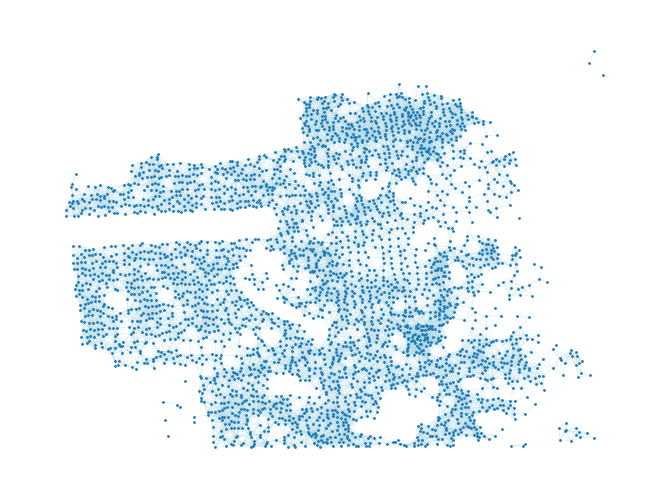

In [231]:
nx.draw(graph, pos={n: list(p.coords)[0] for n, p in df_b.set_index("block")["geometry"].items()}, edge_color="lightblue", node_size=1, width=0.2)

In [ ]:
def compute_features():
    # Compute basic spatial features for each parcel
    pass